# Machine Learning for Advertising

# Loading the training data

The first step is to load the training data into the dataframe. 

To do this we need to do the following:
    1. Define the schema of the data
    2. Load the data into a dataframe using spark's read functionalities

### Load Impressions Dataset

In [1]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

In [2]:
from pyspark.sql.types import *


impressions = "<%ImpressionsFile%>"
                      
impdf = spark.read.parquet(impressions)            

### Load Activity Dataset

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

activities = "<%ActivitiesFile%>"

actdf = spark.read.parquet(activities)


### Drop Duplicate Records from Impression table for the given coloumns

In [4]:
imp_df = impdf.select('User_ID','Browser_Platform_ID','Operating_System_ID','Ad_ID').dropDuplicates()
imp_df.cache()
imp_df.count()

12260

### Drop Duplicate Records from Activity table for the given coloumns

In [5]:
act_df = actdf.select('User_ID','Browser_Platform_ID','Operating_System_ID','Ad_ID').dropDuplicates()
act_df.cache()
act_df.count()

9145

### Find the records who are converted in Impression Table -> (Impressions All <-filter-> Activity = Converted)

In [6]:
conv_imp = imp_df.join(act_df,["User_ID"]).filter(imp_df.Browser_Platform_ID == act_df.Browser_Platform_ID).filter(imp_df.Operating_System_ID == act_df.Operating_System_ID).filter(imp_df.Ad_ID == act_df.Ad_ID).drop(act_df.Browser_Platform_ID).drop(act_df.Operating_System_ID).drop(act_df.Ad_ID)

In [7]:
conv_imp.count()

9145

### Find the records who are Not converted in Impression Table -> (Impressions All - Converted = Not Converted)

In [8]:
notconv_imp=imp_df.select('User_ID','Browser_Platform_ID','Operating_System_ID','Ad_ID').subtract(conv_imp.select('User_ID','Browser_Platform_ID','Operating_System_ID','Ad_ID'))

### Not Converted Records - labeled converted with values 0.0

In [9]:
imp_not_conv = notconv_imp.withColumn("purchased",lit(0).cast(DoubleType()))
imp_not_conv.count()

3115

### Converted Records - labeled converted with values 1.0

In [10]:
imp_conv = conv_imp.withColumn("purchased",lit(1).cast(DoubleType()))
imp_conv.count()

9145

### Final  Impression table with the records (Converted Union NonConverted)

In [11]:
imp_final = imp_conv.unionAll(imp_not_conv)
imp_final.printSchema()
imp_final.count()

root
 |-- User_ID: string (nullable = true)
 |-- Browser_Platform_ID: string (nullable = true)
 |-- Operating_System_ID: string (nullable = true)
 |-- Ad_ID: string (nullable = true)
 |-- purchased: double (nullable = false)



12260

# Featurization - One Hot Encodeing

In [12]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

'''
Utilize a StringIndexer to encode a column of strings to 
a column of indices.
'''
indexerA = StringIndexer()
indexerA.setInputCol("Browser_Platform_ID")
indexerA.setOutputCol("browser_index")

indexerB = StringIndexer()
indexerB.setInputCol("Operating_System_ID")
indexerB.setOutputCol("os_index")

indexerC = StringIndexer()
indexerC.setInputCol("Ad_ID")
indexerC.setOutputCol("ad_index")

'''
Use the OneHotEncoder transformer to map a column of  
indices to a column of binary vectors, where each vector
has at most one dimension as non-zero (unity) value.
'''
encoderA = OneHotEncoder()
encoderA.setInputCol("browser_index")
encoderA.setOutputCol("browser_features")

encoderB = OneHotEncoder()
encoderB.setInputCol("os_index")
encoderB.setOutputCol("os_features")

encoderC = OneHotEncoder()
encoderC.setInputCol("ad_index")
encoderC.setOutputCol("ad_features")

OneHotEncoder_49ddb390be150724874e

# Explore the features

In [13]:
indexermodelA = indexerA.fit(imp_final)
tempdf1 = indexermodelA.transform(imp_final)
tempdf2 = encoderA.transform(tempdf1)

indexermodelB = indexerB.fit(tempdf2)
tempdf3 = indexermodelB.transform(tempdf2)
tempdf4 = encoderB.transform(tempdf3)

indexermodelC = indexerC.fit(tempdf4)
tempdf5 = indexermodelC.transform(tempdf4)
encodedFinal = encoderC.transform(tempdf5)


## Test , Train Data Split

In [14]:
from pyspark.sql.functions import rand

samplingFraction = 0.25;
trainingFraction = 0.75; testingFraction = (1-trainingFraction);
seed = 1234;

trainData, testData = imp_final.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE TRAIN AND TEST DATA
trainData.cache()
testData.cache()
trainData.count(),testData.count()

(9217, 3043)

In [15]:
filter_notconv = trainData.filter("purchased == 0.0")
filter_conv = trainData.filter("purchased == 1.0")
filter_notconv.count(),filter_conv.count()

filter_conv_sample = filter_conv.sample(False, 0.4, 42)
filter_conv_sample.count()

traindf = filter_conv_sample.unionAll(filter_notconv)
traindf.count()

5034

# Analyzing the label distribution

First we analyze the distribution of our target labels using a histogram

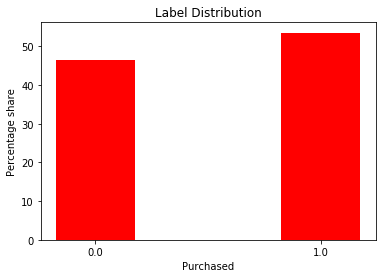

In [16]:
import matplotlib.pyplot as plt

negcount = traindf.filter("purchased == 0.0").count()
poscount = traindf.filter("purchased == 1.0").count()

negfrac = 100*float(negcount)/float(negcount+poscount)
posfrac = 100*float(poscount)/float(poscount+negcount)
ind = [0.0,1.0]
frac = [negfrac,posfrac]
width = 0.35

plt.title('Label Distribution')
plt.bar(ind, frac, width, color='r')
plt.xlabel("Purchased")
plt.ylabel('Percentage share')
plt.xticks(ind,['0.0','1.0'])
plt.show()

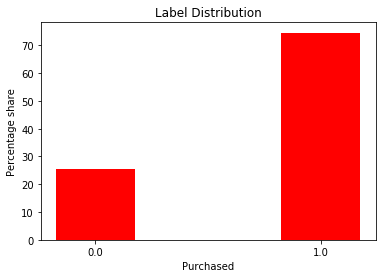

In [17]:
import matplotlib.pyplot as plt

negcount = testData.filter("purchased == 0.0").count()
poscount = testData.filter("purchased == 1.0").count()

negfrac = 100*float(negcount)/float(negcount+poscount)
posfrac = 100*float(poscount)/float(poscount+negcount)
ind = [0.0,1.0]
frac = [negfrac,posfrac]
width = 0.35

plt.title('Label Distribution')
plt.bar(ind, frac, width, color='r')
plt.xlabel("Purchased")
plt.ylabel('Percentage share')
plt.xticks(ind,['0.0','1.0'])
plt.show()

# Model Training

We utilize a LogisticRegression classsifier for our ML model. 

VectorAssembler Transformer is used to collect the transformers and Estimators into a Single feature Vector


In [18]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler()
assembler.setInputCols(["browser_features", "os_features","ad_features"])
assembler.setOutputCol("features")


VectorAssembler_49a9b4cf0047da94346b

In [50]:
from sagemaker_pyspark import IAMRole, S3DataPath
from sagemaker_pyspark.algorithms import *
from sagemaker import get_execution_role
from sagemaker_pyspark import *


estimator = LinearLearnerBinaryClassifier(
    sagemakerRole=IAMRole(role),
    trainingInstanceType="ml.m4.xlarge",
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge",
    endpointInitialInstanceCount=1,
    trainingSparkDataFormatOptions={
        "featuresColumnName":"features",
        "labelColumnName":"purchased"
    },
    namePolicyFactory=RandomNamePolicyFactory("adClasHyp1"),
    endpointCreationPolicy=EndpointCreationPolicy.CREATE_ON_TRANSFORM)


estimator.setFeatureDim(25)
estimator.setLoss('logistic')
estimator.binary_classifier_model_selection_criteria='recall_at_target_precision'
estimator.target_recall=0.9
estimator.positive_example_weight_mult='balanced'
estimator.epochs=40



# Setting up an ML Pipeline

In [51]:
from pyspark.ml import Pipeline

trainingpipeline = Pipeline(stages=[indexerA,encoderA,
                                    indexerB,encoderB,
                                    indexerC,encoderC,                    
                                    assembler,estimator])

# Training the Pipeline Model

In [52]:
%%time
model = trainingpipeline.fit(traindf)

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 16min 51s


# Compute predictions

In [53]:
testDataPredictions = model.transform(testData)
testDataPredictions.show()

+--------------------+-------------------+-------------------+---------+---------+-------------+----------------+--------+---------------+--------+-------------+--------------------+-------------------+---------------+
|             User_ID|Browser_Platform_ID|Operating_System_ID|    Ad_ID|purchased|browser_index|browser_features|os_index|    os_features|ad_index|  ad_features|            features|              score|predicted_label|
+--------------------+-------------------+-------------------+---------+---------+-------------+----------------+--------+---------------+--------+-------------+--------------------+-------------------+---------------+
|A1htmYYc0x9Lfb_Cm...|                 26|                 13|934026699|      1.0|          0.0|   (9,[0],[1.0])|     4.0| (15,[4],[1.0])|     1.0|    (1,[],[])|(25,[0,13],[1.0,1...| 0.7730217576026917|            1.0|
|A1sN5YHp1h9SstIw_...|                  5|                  2|994726652|      1.0|          1.0|   (9,[1],[1.0])|     5.0| (

# Estimating the Model performance

Having trained the model, the next step is to evaluate its performance on the test data. This is achieved as follows:

    Load the test data into a dataframe.
    Score the test dataframe using the model.
    Compute the AUC metric based on the model scores on the test data.
    Plot the ROC curve to better understand the model performance.

# Confusion Matrix

In [57]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

outdataframe = testDataPredictions.select("purchased","predicted_label")
pandadf = outdataframe.toPandas()
npmat = pandadf.as_matrix()
labels = npmat[:,0]
predicted_label = npmat[:,1]

cnf_matrix = confusion_matrix(labels, predicted_label)


In [58]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Purchased')
    plt.xlabel('Predicted \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

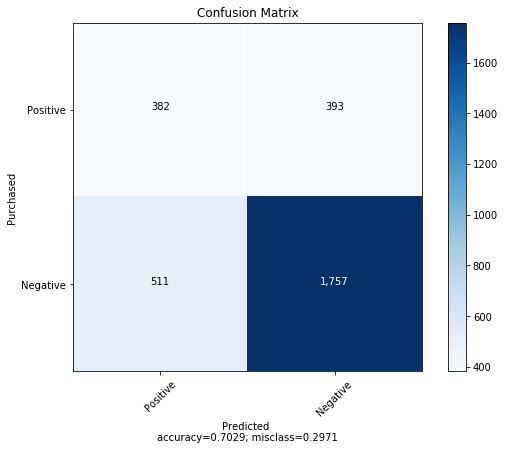

In [59]:
plot_confusion_matrix(cnf_matrix,
                      normalize    = False,
                      target_names = ['Positive', 'Negative'],
                      title        = "Confusion Matrix")

In [60]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# Instantiate metrics object
predictionAndLabels = testDataPredictions.rdd.map(lambda lp: (float(lp.score), lp.purchased))

metrics = BinaryClassificationMetrics(predictionAndLabels)


# Compute AUC

In [61]:
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


Area under PR = 0.864068321743
Area under ROC = 0.6849291688


# Plot ROC

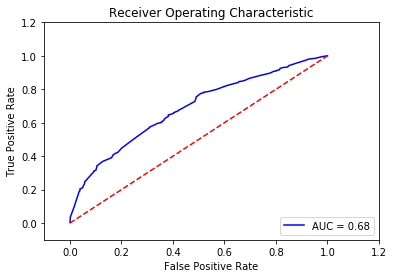

In [62]:
from pyspark.sql.functions import udf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

'''
To plot the ROC curve, we need the probability scores as predicted
by our model. However our model outputs a probability vector for each
record where it separately provides the probability for class 0 and also
for class 1. We first write a user-defined function to extract the 
probability for the positive '1' class from the probability vector.
'''

outdf = testDataPredictions.select("purchased","score")
pdf = outdf.toPandas()
npmat = pdf.as_matrix()
labels = npmat[:,0]
probs = npmat[:,1]

'''
We compute the false positive rate and true positive rate at various thresholds
of the probability score and use that to recompute the auc and finally to 
plot the ROC curve.
'''
false_positive_rate, true_positive_rate, thresholds = roc_curve(labels, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot PR Curve

Average precision-recall score: 0.86


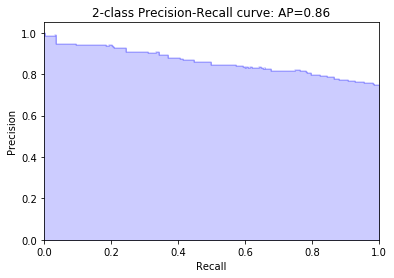

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(labels, probs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(labels, probs)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
         average_precision))
plt.show()


# Memory Cleanup

In [64]:
testData.unpersist()
trainData.unpersist()
imp_df.unpersist()
act_df.unpersist()

DataFrame[User_ID: string, Browser_Platform_ID: string, Operating_System_ID: string, Ad_ID: string]